# Assignment 5
###

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, abs, split, trim

In [2]:
# create spark session
spark = SparkSession.builder.appName("ChessA5").getOrCreate()

# read chess games data and filter for rated games with 10-150 turns
df = spark.read.csv("games.csv", header=True, inferSchema=True).filter((col("rated") == True) & (col("turns") >= 10) & (col("turns") <= 150))

In [3]:
# create dataframe with simplified opening names and rating differences
turn_df = df.withColumn("opening_simplified", trim(split(col("opening_name"), ":").getItem(0))) \
    .withColumn("rating_diff", abs(col("white_rating") - col("black_rating"))).select("turns", "rating_diff", "opening_simplified", "increment_code", "victory_status", "winner")

# split data into training and test sets (80/20)
trainDF, testDF = turn_df.randomSplit([.8, .2], seed=42)

In [8]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

# create indexers to convert categorical columns to numeric
opening_indexer = StringIndexer(inputCol="opening_simplified", outputCol="opening_index", handleInvalid="keep")
increment_indexer = StringIndexer(inputCol="increment_code", outputCol="increment_index", handleInvalid="keep")
victory_indexer = StringIndexer(inputCol="victory_status", outputCol="victory_index", handleInvalid="keep")
winner_indexer = StringIndexer(inputCol="winner", outputCol="winner_index", handleInvalid="keep")

# define feature columns for model input
feature_cols = ["rating_diff", "opening_index", "increment_index", "victory_index", "winner_index"]
# combine features into single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [9]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# create random forest model with 400 bins for feature discretization
rf = RandomForestRegressor(featuresCol="features", labelCol="turns", maxBins=400)

# create pipeline with feature engineering and model
pipeline = Pipeline(stages=[opening_indexer, increment_indexer, victory_indexer, winner_indexer, assembler, rf])

# fit model to training data
model = pipeline.fit(trainDF)

# make predictions on test data
predictions = model.transform(testDF)

In [10]:
# train the model
model = pipeline.fit(trainDF)

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

# calculate rmse on test predictions
predictions = model.transform(testDF)
evaluator = RegressionEvaluator(labelCol="turns", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error: " + str(rmse))

Root Mean Squared Error: 28.544900694613652


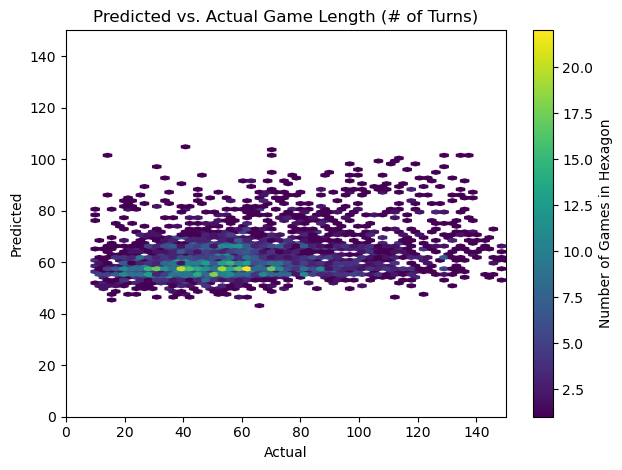

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = predictions.select("turns", "prediction").toPandas()

# create hexbin plot of predicted vs. actual game length
hb = plt.hexbin(
    x=plot_df['turns'],
    y=plot_df['prediction'],
    gridsize=50,
    mincnt=1
)
plt.colorbar(hb, label='Number of Games in Hexagon')

plt.title('Predicted vs. Actual Game Length (# of Turns)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.tight_layout()
plt.show()

In [13]:
import pyspark.sql.functions as F

# create dataframe with simplified opening names and rating differences
white_games = df.select(col("white_id").alias("player_id"), col("white_rating").alias("rating"), "moves")
black_games = df.select(col("black_id").alias("player_id"), col("black_rating").alias("rating"), "moves")
all_player_games = white_games.union(black_games)

In [14]:
# partition data by player id and randomize order
player_window = Window.partitionBy("player_id").orderBy(F.rand(seed=42))

In [15]:
# filter for rated games with at least 5 turns and add game number per player
per_player_df = df.selectExpr(
    "stack(2, white_id, white_rating, moves, rated, turns, black_id, black_rating, moves, rated, turns) as (player_id, rating, moves, rated, turns)"
)
per_player_df = per_player_df.filter((F.col("rated") == True) & (F.col("turns") >= 5)).withColumn("game_num", F.row_number().over(player_window))

# keep only first 100 games per player
player_moves_df = per_player_df.filter(F.col("game_num") <= 100).groupBy("player_id")

# calculate average rating and concatenate all moves for each player
player_moves_df = player_moves_df.agg(F.avg("rating").alias("actual_rating"), F.concat_ws(" ", F.collect_list("moves")).alias("all_moves"))

In [16]:
# split data into training and test sets (80/20)
trainDF, testDF = player_moves_df.randomSplit([.8, .2], seed=42)

In [17]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

# tokenize moves into individual tokens
tokenizer = Tokenizer(inputCol="all_moves", outputCol="move_tokens")

# convert tokens to term frequency vectors
hashing_tf = HashingTF(inputCol="move_tokens", outputCol="raw_features", numFeatures=2**12)

# compute inverse document frequency
idf = IDF(inputCol="raw_features", outputCol="features")

In [18]:
# create random forest regressor to predict ratings
rf = RandomForestRegressor(featuresCol="features", labelCol="actual_rating")

# create pipeline with all preprocessing and model stages
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, rf])

In [19]:
# train the model
model = pipeline.fit(trainDF)

In [20]:
# calculate rmse on predictions
predictions = model.transform(testDF)
evaluator = RegressionEvaluator(labelCol="actual_rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error: " + str(rmse))

Root Mean Squared Error: 257.6654517140287


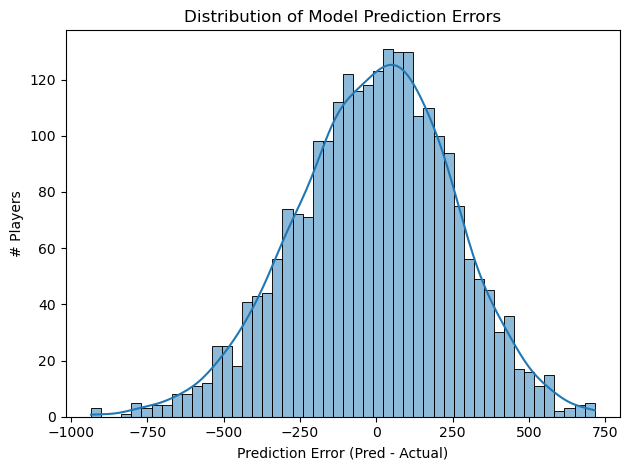

In [21]:
# create dataframe with actual and predicted ratings
predictions_pd = predictions.select("actual_rating", "prediction").toPandas()

# calculate prediction errors
predictions_pd['error'] = predictions_pd['prediction'] - predictions_pd['actual_rating']

# create histogram of prediction errors
sns.histplot(data=predictions_pd, x="error", kde=True, bins=50)
plt.title('Distribution of Model Prediction Errors',)
plt.xlabel('Prediction Error (Pred - Actual)')
plt.ylabel('# Players')
plt.tight_layout()
plt.show()